## Machine Learning
#### MIIA 4200 (2019-I) - Proyecto 1
## Predicción de precios de vehículos usados

<p>Profesor:  Alejandro Correa Bahnsen</p>
<p>Estudiantes: Cristina Sierra Alcala - Oscar Andrés Mosquera - Eduardo Daniel Chain</p>

## Exploración preliminar de datos
#### Carga de los datos

- Se realiza la carga de los datos y la respectivas librerias

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics, neighbors
from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.ensemble import RandomForestRegressor

from matplotlib.legend_handler import HandlerLine2D

from pprint import pprint
from flask import Flask
from flask_restplus import Api, Resource, fields

import dash
import dash_core_components as dcc
import dash_html_components as html

import pickle

import warnings
warnings.filterwarnings('ignore')

# plot styles
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')

### Descrpción

- 1.2 millones de listados extraídos de TrueCar.com - Conjunto de datos de precios, kilometraje, marca y modelo de Kaggle: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings)
- Cada observación representa el precio de un automóvil usado.

In [2]:
data = pd.read_csv('dataTrain_carListings.csv')

In [7]:
data.head()

,Price,Year,Mileage,State,Make,Model
0,8995,2014,35725,TX,Acura,ILX6-Speed
1,10888,2013,19606,NY,Acura,ILX5-Speed
2,8995,2013,48851,TX,Acura,ILX6-Speed
3,10999,2014,39922,CO,Acura,ILX5-Speed
4,14799,2016,22142,UT,Acura,ILXAutomatic


- Revisión de dimensiones del dataframe

In [4]:
data.shape

(500000, 6)

- Identificar las características de los atributos númericos

In [5]:
data.describe()

,Price,Year,Mileage
count,500000.000000,500000.000000,5.000000e+05
mean,21144.186304,2013.197174,5.507643e+04
std,10753.259704,3.290135,4.089704e+04
min,5001.000000,1997.000000,5.000000e+00
25%,13499.000000,2012.000000,2.585500e+04
50%,18450.000000,2014.000000,4.299000e+04
75%,26998.000000,2016.000000,7.740600e+04
max,79999.000000,2018.000000,2.457832e+06


Se observa que el precio de los carros de la base de datos oscilan entre 5000 y 80000 mil dólares. También se observa que el carro más antiguo es modelo 1997 mientras que el más reciente es del año 2018. Por último, se destaca que existe una elevada dispersión en el kilometraje de los automóviles.

- Identificar la cantidad de Missing Values para cada columna

In [6]:
missing_values = data.isnull().sum()
missing_values

Price      0
Year       0
Mileage    0
State      0
Make       0
Model      0
dtype: int64

- Verificar los valores de los atributos categóricos

In [7]:
cat_val = ["State", "Make", "Model"]

for col in cat_val:
    print ([col]," : ",data[col].unique())

['State']  :  [' MD' ' KY' ' SC' ' OK' ' TN' ' FL' ' NH' ' WI' ' NY' ' TX' ' NJ' ' MI'
 ' AL' ' CA' ' NC' ' GA' ' OR' ' OH' ' AR' ' VA' ' WA' ' IL' ' AZ' ' MA'
 ' CO' ' MN' ' KS' ' PA' ' MO' ' SD' ' IN' ' NE' ' UT' ' NM' ' HI' ' NV'
 ' DE' ' MS' ' ID' ' IA' ' ME' ' CT' ' MT' ' VT' ' WV' ' LA' ' ND' ' AK'
 ' RI' ' WY' ' DC']
['Make']  :  ['Nissan' 'Chevrolet' 'Hyundai' 'Jeep' 'Ford' 'Kia' 'Mercedes-Benz'
 'Dodge' 'GMC' 'Toyota' 'Honda' 'Volkswagen' 'Cadillac' 'Volvo' 'BMW'
 'Subaru' 'Chrysler' 'Buick' 'Ram' 'Lexus' 'Porsche' 'Audi' 'Lincoln'
 'MINI' 'INFINITI' 'Scion' 'Land' 'Acura' 'Mazda' 'Mercury' 'Mitsubishi'
 'Pontiac' 'Jaguar' 'Bentley' 'Suzuki' 'FIAT' 'Tesla' 'Freightliner']
['Model']  :  ['MuranoAWD' 'CamaroCoupe' 'Santa' 'Grand' 'Wrangler' 'F-1504WD'
 'ExplorerXLT' 'Sonata4dr' 'SorentoSX' 'M-ClassML350' 'JourneyFWD' 'Super'
 'Sierra' 'Silverado' 'CamryLE' 'OdysseyEX-L' 'Pathfinder4WD' 'AcadiaFWD'
 'EscapeSE' 'Express' 'F-150XLT' 'EdgeSEL' 'Passat4dr' 'EdgeSport'
 'FlexLimited' 

## Visualización
### Matriz de dispersión e Histograma de "precios"

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000230B1DA62B0>,
      dtype=object)

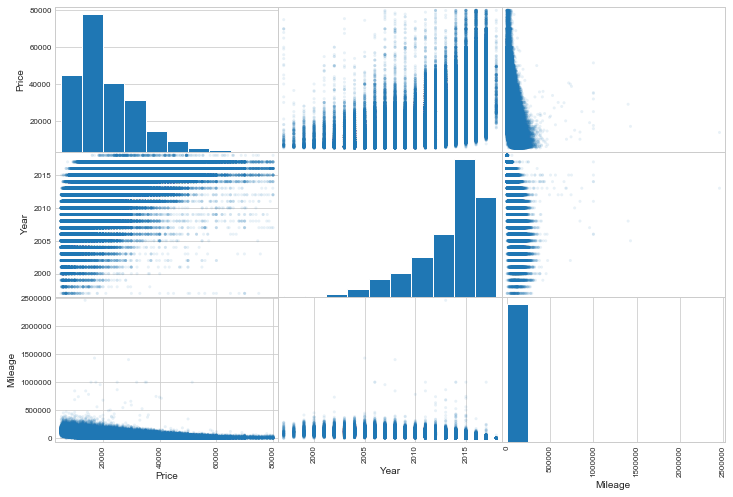

In [8]:
num_attributes = ["Price", "Year", "Mileage"]
pd.plotting.scatter_matrix(data[num_attributes], figsize = (12,8), alpha = 0.1)

Se observa que existe una relación entre año y precio, los automóviles más recientes tienen ejemplares que alcanzan precios más elevados que los modelos antiguos, cabe mencionar que la mayor parte de automóviles son del 2012 en adelante. Adicionalmente, existe una relación entre millas y precio, en la que se resalta que aquellos automóviles con mayor kilometraje tienen precios más bajos.

data["Price"].hist(bins = 50, log = True)

## Limpieza de datos

- Convertir el año a int

In [9]:
data.Year = data.Year.astype('int')

- A continuación se analiza la variable millas, puesto que presenta valores muy bajos  y muy alejados, consecuente con la alta dispersión ya observada.

In [10]:
data[['Year','Make','Model','Mileage']].sort_values(by='Mileage',ascending=True).head(5)

,Year,Make,Model,Mileage
155188,2016,Kia,RioLX,5
365405,2017,Ford,EscapeFWD,5
245854,2017,Dodge,JourneySXT,5
387449,2016,Chevrolet,Silverado,5
42835,2013,Chevrolet,EquinoxFWD,5


In [11]:
data[['Year','Make','Model','Mileage']].sort_values(by='Mileage',ascending=False).head(5)

,Year,Make,Model,Mileage
96163,2013,Chevrolet,Silverado,2457832
110216,2005,Ford,Super,1428913
115646,2008,GMC,Sierra,1401471
202266,2006,Ford,Super,999999
451313,2011,Chevrolet,Silverado,999999


- Se podría limitar las millas a por lo menos 500 para descartar algunos "nuevos" autos usados y a no más de 300k

In [12]:
print ('Autos con menos de 500 millas: %s' % data.Mileage[data.Mileage < 500].count())
print ('\nAutos con más de 300K millas: %s' % data.Mileage[data.Mileage > 300000].count())

Autos con menos de 500 millas: 2608

Autos con más de 300K millas: 202


- Revisar los precios más altos / más bajos y ver si tienen sentido.

In [13]:
data[['Year','Make','Model','Mileage','Price']].sort_values(by='Price',ascending=False).head(5)

,Year,Make,Model,Mileage,Price
134981,2018,Land,Rover,649,79999
159375,2016,Lexus,LXLX,16118,79999
85765,2014,Land,Rover,33168,79999
394342,2016,Land,Rover,30055,79999
439227,2015,Land,Rover,33780,79999


In [14]:
data[['Year','Make','Model','Mileage','Price']].sort_values(by='Price',ascending=True).head(5)

,Year,Make,Model,Mileage,Price
486979,2009,Hyundai,Accent4dr,109607,5001
281977,2011,Kia,Forte,124271,5001
153008,2009,Ford,Escape4WD,169579,5001
149778,2005,Toyota,Camry4dr,164552,5002
146677,2008,Honda,CivicLX,189174,5002


In [15]:
data[['Price','Mileage']].describe().T

,count,mean,std,min,25%,50%,75%,max
Price,500000.0,21144.186304,10753.259704,5001.0,13499.0,18450.0,26998.0,79999.0
Mileage,500000.0,55076.426352,40897.041303,5.0,25855.0,42990.0,77406.0,2457832.0


## Análisis exploratorio de datos

- Identificar cuantos años, fabricantes y modelos hay en el datset

In [16]:
print ('Número de años unicos; %s' % len(data.Year.unique()))
print ('Número de fabricantes unicos: %s' % len(data.Make.unique()))
print ('Número de modelos unicos: %s' % len(data.Model.unique()))

Número de años unicos; 22
Número de fabricantes unicos: 38
Número de modelos unicos: 525


- Distribución de datos vs año.

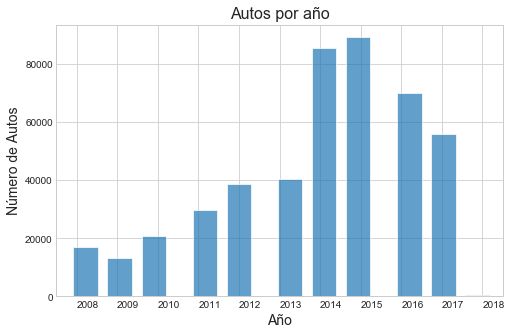

In [17]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
sns.distplot(data.Year,kde=False, hist_kws={"alpha":0.7,'width':0.6})
plt.title('Autos por año',fontsize=16)
plt.xticks(sorted(data.Year.unique()),horizontalalignment='left')
plt.ylabel('Número de Autos',fontsize=14)
plt.xlabel('Año', fontsize=14)
plt.xlim(2007.5,2018.5)
plt.show()

Se observa que la mayor concentración de automóviles está en los modelos de 2015 a 2017.

- Revisar la distribución general de millas

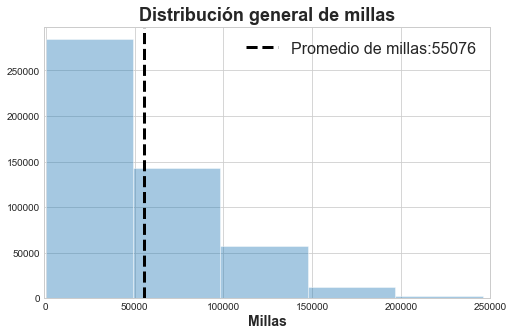

In [18]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
sns.distplot(data.Mileage,kde=False)
plt.xlabel('Millas',fontsize=14,fontweight="bold")
plt.axvline(data.Mileage.mean(),lw=3,ls='dashed',
            color='black',label='Promedio de millas:'+'{0:.0f}'.format(np.mean(data.Mileage)))
plt.title('Distribución general de millas',fontsize=18,fontweight="bold")
plt.legend(loc='upper right',fontsize=16)
plt.xlim(-1000,250000)
plt.show()

En general, la mayoría de automóviles tienen kilometraje inferior a 50000 millas lo cual tiene sentido con los hallazgos anteriores, en los que la mayoría de carros son modelos recientes, lo que haría esperar que estos carros tengan menor kilometraje y por eso los resultados de esta gráfica.

- Distribución de millas por año. Diagrama de caja para tener una mejor idea de los rangos y los posibles valores.

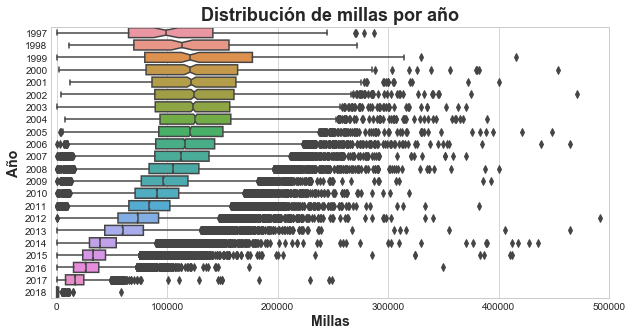

In [19]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
sns.boxplot(x='Mileage',y='Year',data=data,notch=True,orient='h')
plt.xlabel('Millas',fontsize=14,fontweight="bold")
ax.set_yticklabels(sorted(data.Year.unique()))
plt.ylabel('Año',fontsize=14,fontweight="bold")
plt.title('Distribución de millas por año',fontsize=18,fontweight="bold")
plt.xlim(-5000,500000)
plt.show()

Como se mencionó anteriormente la relación esperada entre año y millas se cumple, en la que los carros más recientes tienen menor kilometraje. Sin embargo, existe alta dispersión para los automóviles modelo 2006-2011 con un rango de precios muy volátil.

- Se analiza las millas por fabricante y se gráfican los precios altos para que sea más informativo.

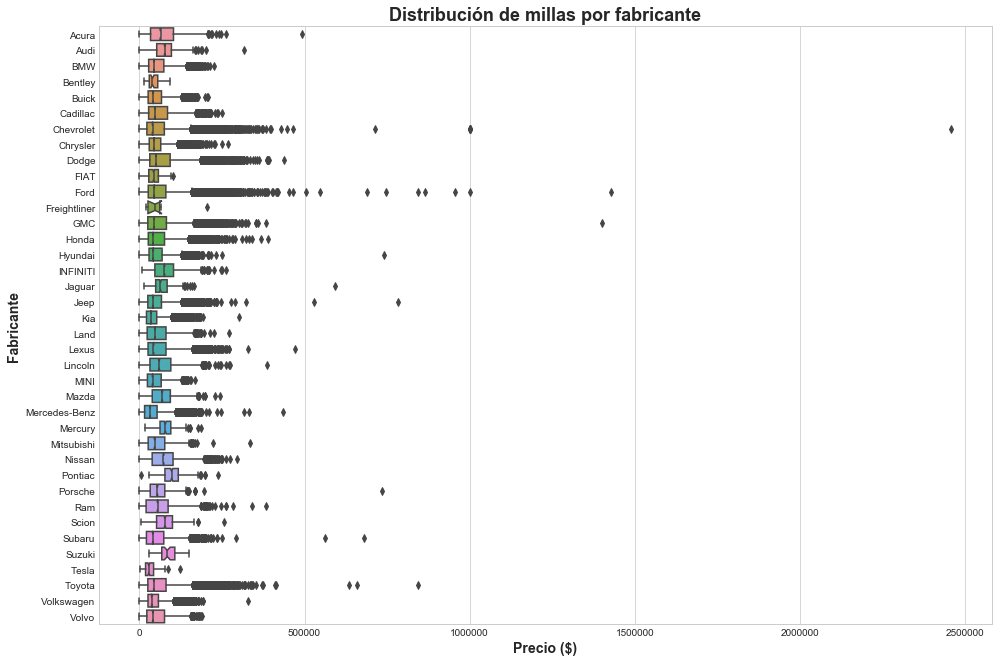

In [20]:
fig = plt.figure(figsize=(16,11))
ax = fig.gca()
sns.boxplot(x='Mileage',y='Make',data=data, order=sorted(data.Make.unique()),notch=True,orient='h')
plt.xlabel('Precio ($)',fontsize=14,fontweight="bold")
plt.ylabel('Fabricante',fontsize=14,fontweight="bold")
plt.title('Distribución de millas por fabricante',fontsize=18,fontweight="bold")
plt.show()

- Distribución general de precios. Limitando los datos utilizados para este gráfico a 80k en el extremo superior, ya que se reduce bastante para alcanzar el precio más alto de $ 2M.

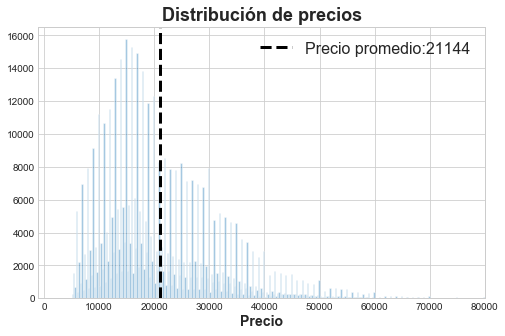

In [21]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
sns.distplot(data.Price,kde=False,bins=300)
plt.xlabel('Precio',fontsize=14,fontweight="bold")
plt.axvline(data.Price.mean(),lw=3,ls='dashed', color='black',label='Precio promedio:'+'{0:.0f}'.format(np.mean(data.Price)))
plt.title('Distribución de precios',fontsize=18,fontweight="bold")
plt.legend(loc='upper right',fontsize=16)
plt.xlim(-1000,80000)
plt.show()

- Distribución de precios por año

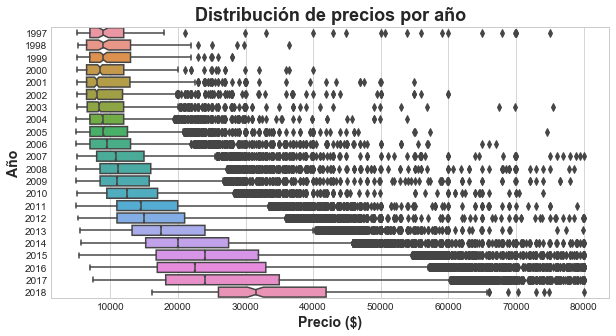

In [22]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
sns.boxplot(x='Price',y='Year',data=data[data.Price < 80000],
            order=sorted(data.Year.unique()),notch=True,orient='h')
plt.xlabel('Precio ($)',fontsize=14,fontweight="bold")
plt.ylabel('Año',fontsize=14,fontweight="bold")
plt.title('Distribución de precios por año',fontsize=18,fontweight="bold")
plt.show()

A nivel general, se observa que existe una relación positiva entre precio y año, tal y como se espera. Sin embargo, existen varios casos que generan ruido, especialmente los modelos de carros muy antiguos con precios tan elevados como los más recientes. 

- Precios por fabricante

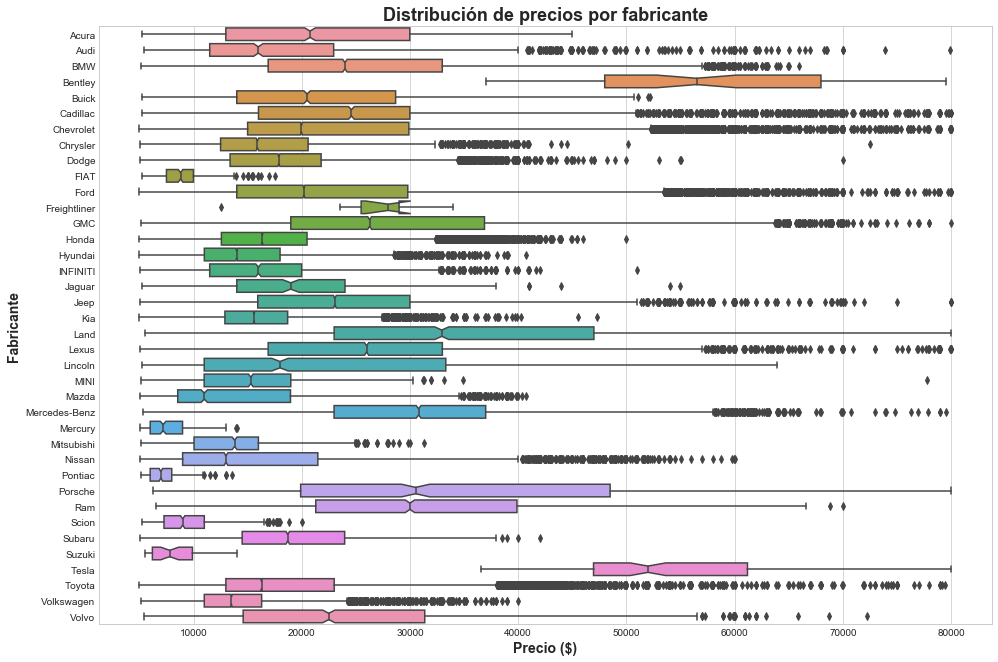

In [23]:
fig = plt.figure(figsize=(16,11))
ax = fig.gca()
sns.boxplot(x='Price',y='Make',data=data[data.Price < 150000],
            order=sorted(data.Make.unique()),notch=True,orient='h')
plt.xlabel('Precio ($)',fontsize=14,fontweight="bold")
plt.ylabel('Fabricante',fontsize=14,fontweight="bold")
plt.title('Distribución de precios por fabricante',fontsize=18,fontweight="bold")
plt.show()

La gráfica anterior muestra que incluso con una marca específica, puede haber variaciones de precios muy grandes. De hecho, son muy pocos los casos en los que todos los datos hacen parte de la distribución sin alejarse significativamente de la media, como lo son Suzuki, Tesla, Bentley y Acura, pero en el resto de los casos existe una alta dispersión en los precios, por lo que es necesario el análisis de otras variables para entender el comportamiento del precio. 

## Modelamiento

- Creación de variables continuas con base en la frecuencia de las variables categoricas.

In [5]:
data['Model2'] =data.groupby('Model')['Model'].transform('count')
data['State2'] =data.groupby('State')['State'].transform('count')
data['Make2'] = data.groupby('Make')['Make'].transform('count')

In [6]:
data.head()

,Price,Year,Mileage,State,Make,Model,Model2,State2,Make2
0,21490,2014,31909,MD,Nissan,MuranoAWD,2088,10327,13168
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe,3592,8331,72900
2,20925,2016,24633,SC,Hyundai,Santa,6229,6026,18856
3,14500,2012,84026,OK,Jeep,Grand,15382,6374,30413
4,32488,2013,22816,TN,Jeep,Wrangler,7334,11569,30413


- Codificación de variables categícas usando BinaryEncoder

* El BinaryEncoder puede considerarse como un híbrido de codificadores de hashing y hot-one. Binary crea menos funciones que one-hot, al tiempo que conserva algunos valores únicos en la columna.
    + Las categorías están codificadas por OrdinalEncoder si aún no están en forma numérica.
    + Luego esos números enteros se convierten en código binario, por lo que, por ejemplo, 5 se convierte en 101 y 10 en 1010.
    + Los dígitos de esa cadena binaria se dividen en columnas separadas. Entonces, si hay 4–7 valores en una columna ordinal, entonces se crean 3 nuevas columnas: una para el primer bit, una para el segundo y otra para el tercero.
    + Cada observación se codifica a través de las columnas en su forma binaria.

In [7]:
X = ce.BinaryEncoder().fit_transform(data.drop(['Price'], axis=1))
y = data['Price']

In [8]:
X.head()

,State_0,State_1,State_2,State_3,State_4,State_5,State_6,Make_0,Make_1,Make_2,...,Model_6,Model_7,Model_8,Model_9,Model_10,Year,Mileage,Model2,State2,Make2
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,2014,31909,2088,10327,13168
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,2016,25741,3592,8331,72900
2,0,0,0,0,0,1,1,0,0,0,...,0,0,0,1,1,2016,24633,6229,6026,18856
3,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,2012,84026,15382,6374,30413
4,0,0,0,0,1,0,1,0,0,0,...,0,0,1,0,1,2013,22816,7334,11569,30413


In [25]:
#data = data[(data.Mileage >= 500) & (data.Mileager <= 300000)]

### Test-Train Split

- Para probar el rendimiento de los algoritmos, se divide el conjunto de datos en dos conjuntos distintos de train y test.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

- Para predecir el precio de un auto usado se probaran tres métodos básicos de Machine Learning: regresión lineal, árboles de decisión y bosques aleatorios. RMSE será la principal métrica para evaluar el rendimiento de los modelos. La validación cruzada también se utilizará para seleccionar el modelo con el mejor rendimiento, que luego se afinará.

In [27]:
#Entrenar un modelo de árboles de decisión
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [5]:
#Entrenar un modelo de bosques aleatorios
forest = RandomForestRegressor(n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [29]:
##Entrenar un modelo de regresión lineal
lin_reg = LinearRegression(n_jobs=-1)
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

- Se prueban los modelos en los datos de test, y se evalua en términos de MSE

In [30]:
models= [('lin_reg', lin_reg), ('random forest', forest), ('decision tree', tree)]

for i, model in models:    
    predictions = model.predict(X_test)
    MSE = mean_squared_error(y_test, predictions)
    RMSE = np.sqrt(MSE)
    msg = "%s = %.2f" % (i, round(RMSE, 2))
    print('RMSE of', msg)

RMSE of lin_reg = 8765.95
RMSE of random forest = 3954.02
RMSE of decision tree = 4998.68


- Se puede usar el error porcentual absoluto promedio (MAPE) para calcular una medida de precisión que sea más inmediata de entender.

In [31]:
for i, model in models:
    # Realizar predicciones sobre los datos de entrenamiento.
    predictions = model.predict(X_test)
    # Metricas de desempeño
    errors = abs(predictions - y_test)
    # Calcular el porcentaje de error absoluto (MAPE)
    mape = np.mean(100 * (errors / y_test))
    # Calcular el accuracy
    accuracy = 100 - mape
    
    msg = "%s= %.2f"% (i, round(accuracy, 2))
    print('Accuracy of', msg,'%')

Accuracy of lin_reg= 63.16 %
Accuracy of random forest= 87.87 %
Accuracy of decision tree= 84.85 %


- Al parecer que el modelo de Random Forest es el mejor modelo, ya que su error es el más bajo. Sin embargo, solo se estan evaluando los parametros por default. Para entender mejor el rendimiento de los modelos se usará cross-validation.

### Comparación de modelos

- Para cada modelo se prueban tres métricas de puntuación diferentes. Por lo tanto, los resultados [0] serán lin_reg x MSE,
 resultados [1] lin_reg x MSE y así sucesivamente hasta resultados [8].

In [32]:
models= [('lin_reg', lin_reg), ('forest', forest), ('dt', tree)]
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

results= []
metric= []
for name, model in models:
    for i in scoring:
        scores = cross_validate(model, X_train, y_train, scoring=i, cv=10, return_train_score=True)
        results.append(scores)

In [33]:
results[8]

{'fit_time': array([2.32167053, 2.37154436, 2.37019658, 2.41301799, 2.43806052,
        2.39066601, 2.51576304, 2.60209608, 2.31513238, 2.49954224]),
 'score_time': array([0.03048134, 0.03148103, 0.0304811 , 0.03248024, 0.03098226,
        0.03197885, 0.03297853, 0.03397918, 0.03048158, 0.03497791]),
 'test_score': array([0.79217844, 0.79500573, 0.78491212, 0.78320416, 0.78522923,
        0.79298076, 0.79572346, 0.79352554, 0.78379428, 0.79339874]),
 'train_score': array([0.99982258, 0.99982693, 0.99981486, 0.99984676, 0.99980204,
        0.99983624, 0.9998098 , 0.99981398, 0.99981242, 0.99982516])}

- Se calcula para cada combinación la media y la desviación estándar, y se almacena en dataframe todas las métricas para compararlas.

In [34]:
#Regresión Lineal

LR_RMSE_mean = np.sqrt(-results[0]['test_score'].mean())
LR_RMSE_std= results[0]['test_score'].std()

# Ajuste de signos
LR_MAE_mean = -results[1]['test_score'].mean()
LR_MAE_std= results[1]['test_score'].std()
LR_r2_mean = results[2]['test_score'].mean()
LR_r2_std = results[2]['test_score'].std()

#Random Forest
RF_RMSE_mean = np.sqrt(-results[3]['test_score'].mean())
RF_RMSE_std= results[3]['test_score'].std()
RF_MAE_mean = -results[4]['test_score'].mean()
RF_MAE_std= results[4]['test_score'].std()
RF_r2_mean = results[5]['test_score'].mean()
RF_r2_std = results[5]['test_score'].std()

#Arboles de desición
DT_RMSE_mean = np.sqrt(-results[6]['test_score'].mean())
DT_RMSE_std= results[6]['test_score'].std()
DT_MAE_mean = -results[7]['test_score'].mean()
DT_MAE_std= results[7]['test_score'].std()
DT_r2_mean = results[8]['test_score'].mean()
DT_r2_std = results[8]['test_score'].std()

In [35]:
modelDF = pd.DataFrame({
    'Model'       : ['Linear Regression', 'Random Forest', 'Decision Trees'],
    'RMSE_mean'    : [LR_RMSE_mean, RF_RMSE_mean, DT_RMSE_mean],
    'RMSE_std'    : [LR_RMSE_std, RF_RMSE_std, DT_RMSE_std],
    'MAE_mean'   : [LR_MAE_mean, RF_MAE_mean, DT_MAE_mean],
    'MAE_std'   : [LR_MAE_std, RF_MAE_std, DT_MAE_std],
    'r2_mean'      : [LR_r2_mean, RF_r2_mean, DT_r2_mean],
    'r2_std'      : [LR_r2_std, RF_r2_std, DT_r2_std],
    }, columns = ['Model', 'RMSE_mean', 'RMSE_std', 'MAE_mean', 'MAE_std', 'r2_mean', 'r2_std'])

modelDF.sort_values(by='r2_mean', ascending=False)

,Model,RMSE_mean,RMSE_std,MAE_mean,MAE_std,r2_mean,r2_std
1,Random Forest,3870.007551,177636.782286,2438.468915,15.362704,0.869843,0.002166
2,Decision Trees,4920.065158,502986.214211,3059.460748,20.246805,0.789995,0.004783
0,Linear Regression,8731.708292,686790.402756,6690.975693,20.066882,0.339162,0.004187


- Se gráfica la media del RMSE para comparar los modelos

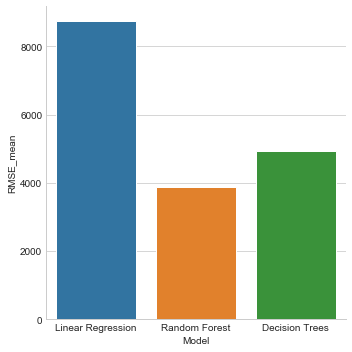

In [36]:
sns.factorplot(x= 'Model', y= 'RMSE_mean', data= modelDF, kind='bar', legend='True')

- Se observa que los árboles de decisión no son tan buenos en comparación con los otros dos métodos, tanto en términos de error como de varianza. El mejor modelo es el random forest.

## Ajuste del Random Forest

### Grid Search
    Utilizando Grid Search se prueban diferentes combinaciones de hiperparámetros de Random Forest
    
* Los hiperparámetros más importantes del Random Forest:

    + n_estimadores = número de árboles
    + max_features = número máximo de funciones consideradas para dividir un nodo
    + max_depth = número máximo de niveles en cada árbol de decisión
    + min_samples_split = número mínimo de puntos de datos colocados en un nodo antes de dividir el nodo
    + min_samples_leaf = número mínimo de puntos de datos permitidos en un nodo hoja
    + bootstrap = método para muestrear puntos de datos (con o sin reemplazo)

In [37]:
# Número de arboles
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)]
# número máximo de funciones consideradas para dividir un nodo
max_features = ['auto', 'sqrt']
# número máximo de niveles en cada árbol de decisión
max_depth = [int(x) for x in np.linspace(20, 50, num = 3)]
max_depth.append(None)
# número mínimo de puntos de datos colocados en un nodo antes de dividir el nodo
#min_samples_split = [5, 10]

param_grid = [
{'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth,
 'bootstrap': [True, False]}
]

grid_search_forest = GridSearchCV(forest, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_forest.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [50, 66, 83, 100, 116, 133, 150, 166, 183, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [20, 35, 50, None], 'bootstrap': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

- Visualización del cambio del RMSE para cada configuración de parámetros

In [38]:
cvres = grid_search_forest.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

3607.8122558607333 {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 50}
3600.862073184064 {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 66}
3599.2307940819414 {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 83}
3596.1484876194822 {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 100}
3594.8643687043864 {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 116}
3594.572837575032 {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 133}
3593.607230223606 {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 150}
3593.5466859919266 {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 166}
3592.8830087106253 {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 183}
3592.2711127689745 {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 2

- Visualizar el mejor modelo a partir de la Grid Search

In [39]:
grid_search_forest.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [40]:
# Metricas de desempeño
grid_best= grid_search_forest.best_estimator_.predict(X_test)
errors = abs(grid_best - y_test)

# Calcular el porcentaje de error absoluto (MAPE)
mape = np.mean(100 * (errors / y_test))

# Calcular el accuracy
accuracy = 100 - mape

print('El mejor modelo de Grid Search tiene una precisión de', round(accuracy, 2),'%')

El mejor modelo de Grid Search tiene una precisión de 88.74 %


In [41]:
#RMSE

grid_mse = mean_squared_error(y_test, grid_best)
grid_rmse = np.sqrt(grid_mse)
print('El mejor modelo de Grid Search tiene un RMSE de', round(grid_rmse, 2))

El mejor modelo de Grid Search tiene un RMSE de 3606.69


### Búsqueda aleatoria

- La búsqueda del Grid Search es demasiado costoso en tiempo de máquina, ya que se prueban muchas combinaciones. Se prueba una búsqueda aleatoria, que evalúa solo un número definido de combinaciones aleatorias para cada hiperparámetro en cada iteración.

In [7]:
# Número de arboles en el random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 3)]
# número máximo de funciones consideradas para dividir un nodo
max_features = ['auto', 'sqrt']
# número máximo de niveles en cada árbol de decisión
max_depth = [int(x) for x in np.linspace(20, 23, num = 3)]
# número mínimo de puntos de datos colocados en un nodo antes de dividir el nodo
min_samples_split = [2, 10]

# Crear el random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

pprint(random_grid)

{'max_depth': [20, 21, 23],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [2, 10],
 'n_estimators': [50, 125, 200]}


- Se usa la "grid" aleatoria para buscar los mejores parámetros.

In [9]:
# Búsqueda aleatoria de parámetros, utilizando 3 veces la validación cruzada
# Busca en 100 combinaciones diferentes y usa todos los núcleos disponibles

rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')

# Ajustar el modelo de búsqueda aleatoria.
rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 63.3min finished


RandomizedSearchCV(cv=2, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [50, 125, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [20, 21, 23], 'min_samples_split': [2, 10]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

- Visualización del cambio del RMSE para cada configuración de parámetro

In [10]:
cvres2 = rf_random.cv_results_
for mean_score, params in zip(cvres2["mean_test_score"], cvres2["params"]):
    print(np.sqrt(-mean_score), params)

3657.0456413250968 {'n_estimators': 200, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 23}
3691.996985401381 {'n_estimators': 125, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 21}
3723.0725625640957 {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 23}
3755.662949402274 {'n_estimators': 50, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 23}
3634.7022047263067 {'n_estimators': 125, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 21}
3728.0553441937004 {'n_estimators': 125, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 23}
3664.892076356276 {'n_estimators': 50, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 21}
3710.8958519433427 {'n_estimators': 50, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 21}
3629.834057501125 {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 20}
3629.6191813848236 {'n_estimators': 200, 'min_samp

- Mejor modelo aleatorio

In [11]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=21,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

- Mejor combinación de parametros según la busqueda aleatoria

In [12]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'max_features': 'auto',
 'max_depth': 21}

- Se evaluan las métricas de rendimiento de el mejor modelo encontrado: MAPE y RMSE.

In [13]:
# Metricas de desempeño (MAPE)
random_best= rf_random.best_estimator_.predict(X_test)
errors = abs(random_best - y_test)

# Calcular el porcentaje de error absoluto (MAPE)
mape = np.mean(100 * (errors / y_test))

# Calcular el accuracy
accuracy = 100 - mape

print('El mejor modelo de Grid Search tiene una precisión de', round(accuracy, 2),'%')

El mejor modelo de Grid Search tiene una precisión de 88.81 %


In [21]:
#RMSE

final_mse = mean_squared_error(y_test, random_best)
final_rmse = np.sqrt(final_mse)
print('El mejor modelo de Grid Search tiene un RMSE de', round(final_rmse, 2))

El mejor modelo de Grid Search tiene un RMSE de 3629.59


- En conclusión, para este caso la busqueda aleatoria tiene mejores metricas que la de la grid.

### Importancia de las características

In [15]:
# Extraer los valores numéricos de importancia de la características de la grid search
importances = rf_random.best_estimator_.feature_importances_

#Crear una lista de características del conjunto de datos original (lista de columnas)
feature_list = list(X.columns)

#Crear una lista de tuplas
feature_importance= sorted(zip(importances, feature_list), reverse=True)

#Crear dos listas de la lista anterior de tuplas
df = pd.DataFrame(feature_importance, columns=['importance', 'feature'])
importance= list(df['importance'])
feature= list(df['feature'])

print(df)

    importance   feature
0     0.272623      Year
1     0.109696   Mileage
2     0.068510    Make_3
3     0.060557    Make_6
4     0.050263    Make_4
5     0.047390   Model_6
6     0.046098   Model_2
7     0.044199   Model_9
8     0.043297  Model_10
9     0.038289   Model_8
10    0.037965   Model_5
11    0.036527   Model_3
12    0.033647   Model_7
13    0.033429    Make_2
14    0.029968   Model_4
15    0.026524    Make_5
16    0.004041    Make_1
17    0.002883   Model_1
18    0.002656   State_6
19    0.002573   State_3
20    0.002311   State_5
21    0.002294   State_4
22    0.002286   State_2
23    0.001974   State_1
24    0.000000   State_0
25    0.000000   Model_0
26    0.000000    Make_0


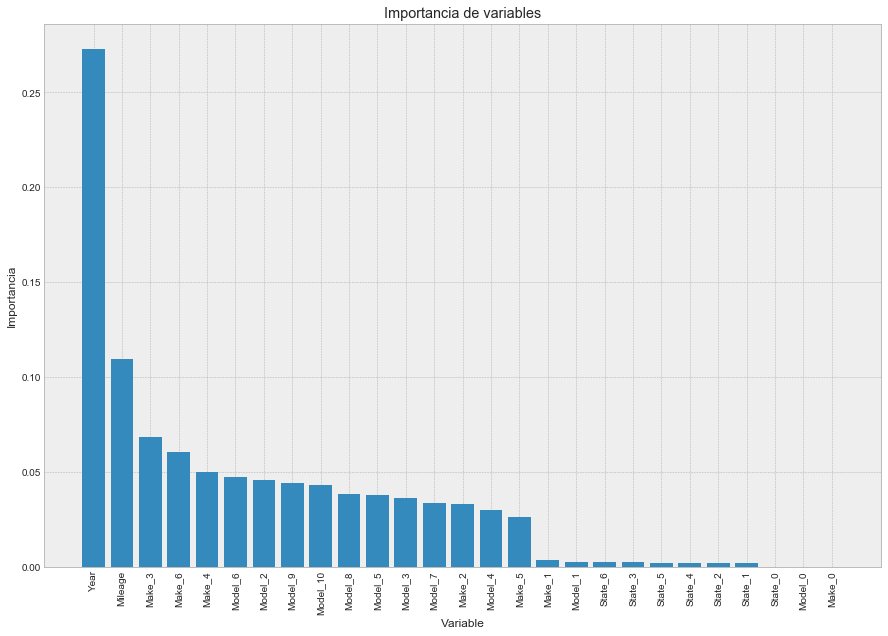

In [18]:
plt.style.use('bmh')

x_values = list(range(len(feature_importance)))

plt.figure(figsize=(15,10))
plt.bar(x_values, importance, orientation = 'vertical')
plt.xticks(x_values, feature, rotation='vertical')

plt.ylabel('Importancia'); plt.xlabel('Variable'); plt.title('Importancia de variables');

- Las mejores características para predecir de manera confiable el precio de una auto usado son el año y las millas de recorrido

### Evaluar el mejor modelo en el test set

In [19]:
final_model = rf_random.best_estimator_

# Predecir en los datos de test
final_pred = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_pred)
final_rmse = np.sqrt(final_mse)
print('El RMSE final en los datos de test es', round(final_rmse, 2))

El RMSE final en los datos de test es 3629.59


In [20]:
#Calcular el accuracy
errors = abs(final_pred - y_test)

# Calcular el porcentaje de error absoluto (MAPE)
mape = np.mean(100 * (errors / y_test))

accuracy = 100 - mape    

print('El mejor modelo logrado en la prueba establece una precisión de', round(accuracy, 2),'%')

El mejor modelo logrado en la prueba establece una precisión de 88.81 %


### Probando otros modelos ...

In [36]:
knn = neighbors.KNeighborsRegressor(n_neighbors=6).fit(X_train, y_train)

y_pred = knn.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

9641.806146755966


In [22]:
regr = RandomForestRegressor(
    random_state=42,
    n_jobs = -1, 
    n_estimators=65, 
    min_samples_split=10, 
    max_depth=23, 
    max_features='sqrt',
    #min_samples_leaf=2,
    bootstrap=True).fit(X_train, y_train)

y_pred = regr.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

3639.5116184019935


In [23]:
regr = RandomForestRegressor(
    random_state=42,
    n_jobs = -1, 
    n_estimators=400, 
    min_samples_split=20, 
    max_depth=23, 
    max_features='auto',
    #min_samples_leaf=2,
    bootstrap=True).fit(X_train, y_train)

y_pred = regr.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

3625.1480258645165


In [5]:
regr = RandomForestRegressor(
    random_state=42,
    n_jobs = -1, 
    n_estimators=65, 
    min_samples_split=10, 
    max_depth=20, 
    max_features='sqrt',
    #min_samples_leaf=2,
    bootstrap=True).fit(X_train, y_train)

y_pred = regr.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

3658.8100997497518


In [10]:
regr = RandomForestRegressor(
    n_estimators=322,
    min_samples_split=2,
    max_depth=20,
    max_features='sqrt',
    bootstrap=True,
    min_samples_leaf=1,
    random_state=None,
    criterion='mse', 
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    min_weight_fraction_leaf=0.0,
    n_jobs=-1,
    oob_score=False,
    verbose=0, 
    warm_start=False).fit(X_train, y_train)

y_pred = regr.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

3636.376827274455


In [11]:
regr = RandomForestRegressor(
    n_estimators=322,
    min_samples_split=2,
    max_depth=20,
    max_features='sqrt',
    bootstrap=True,
    min_samples_leaf=1,
    random_state=None,
    criterion='mse', 
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    min_weight_fraction_leaf=0.0,
    n_jobs=-1,
    oob_score=False,
    verbose=1, 
    warm_start=False).fit(X, y)

y_pred = regr.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 322 out of 322 | elapsed:  8.2min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  8.8min
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed: 16.3min finished


2660.4724493355075


### Visualizar hiperparámetros del Random Forest

- max_depth
    + Max_depth indica qué tan profundo puede ser el árbol. Cuanto más profundo es el árbol, más divisiones tiene y captura más información sobre los datos. Se compara el resultado del entrenamiento con el tets.

Text(0.5,0,'Tree depth')

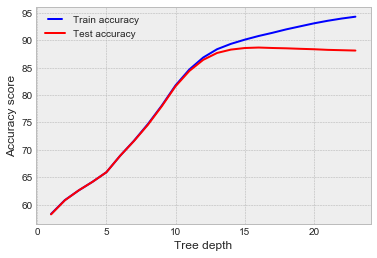

In [24]:
max_depths = np.linspace(1, 23, 23, endpoint=True)

train_results = []
test_results = []

for i in max_depths:
    dt = RandomForestRegressor(max_depth=i)
    dt.fit(X_train, y_train)    
  
    housing_tree = dt.predict(X_train)
    errors = abs(housing_tree - y_train)
    # Calcular el porcentaje de error absoluto (MAPE)
    mape = 100 * (errors / y_train)
    # Calcular el accuracy
    accuracy = 100 - np.mean(mape)
 
    train_results.append(accuracy)
    
   
    housing_tree = dt.predict(X_test)
    errors = abs(housing_tree - y_test)
    # Calcular el porcentaje de error absoluto (MAPE)
    mape = 100 * (errors / y_test)
     # Calcular el accuracy
    accuracy = 100 - np.mean(mape)
    
    test_results.append(accuracy)
    

line1, = plt.plot(max_depths, train_results, 'b', label='Train accuracy')
line2, = plt.plot(max_depths, test_results, 'r', label= 'Test accuracy')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Tree depth')

### Evaluación sobre los datos de envío
- Carga de datos de envío para prueba

In [12]:
data_test = pd.read_csv('dataTest_carListings.csv', index_col=0)

- Codificación de variables categícas usando BinaryEncoder

In [13]:
encoder = ce.BinaryEncoder()
encoder.fit(data.drop(['Price'], axis=1))

BinaryEncoder(cols=['State', 'Make', 'Model'], drop_invariant=False,
       handle_unknown='impute', impute_missing=True, return_df=True,
       verbose=0)

In [14]:
data_test = encoder.transform(data_test)

- Predicción del precio en los datos de envío

In [ ]:
y_pred = regr.predict(data_test)
y_pred = pd.DataFrame(y_pred, index=data_test.index, columns=['Price'])
y_pred.to_csv('test_submission.csv', index_label='ID')

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.5s


## Creando el API.py

### Cargar el dataset

In [ ]:
train1 = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
test1 =  pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTest_carListings.zip', index_col=0)
train1['source']='train'
test1['source']='test'
data = pd.concat([train1, test1],sort=True)
data.to_pickle("df_price_car.pkl")

data = pd.read_pickle("df_price_car.pkl")

### Creación del encoder

In [ ]:
encoder = ce.BinaryEncoder(cols=['Model','State','Make'])
encoder.fit_transform(data)
data=encoder.fit_transform(data)
pickle.dump(encoder, open( 'encoder.sav', "wb" ) )

encoder = pickle.load( open( 'encoder.sav', "rb" ) )

### Entrenar el modelo

In [ ]:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Price','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

# ### X e y, definición de  train y test para entremaiento
X = train.drop(['Price'], axis=1)
y = train['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

## Entrenamiento modelo 
regr = RandomForestRegressor(
     max_depth=20, 
     random_state=42,
     n_jobs = -1, 
     n_estimators=322, 
     min_samples_split=10, 
     max_features='sqrt',
     bootstrap=True).fit(X_train, y_train)


### Salvar el modelo
    - Se salva el modelo como modelRandom.sav para usarlo en el API

In [6]:
filename = 'modelRandom.sav'
pickle.dump(regr, open(filename, 'wb'))

### Cargar el modelo

In [ ]:
model = pickle.load(open('modelRandom.sav', 'rb'))

### Crear el dash

In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)
app.config['suppress_callback_exceptions']=True 

app = dash.Dash()

sup_izq = html.Div([     

				html.Div([   
                        html.Label('Seleccione el año:'),
							dcc.Dropdown(id='Year',
							options=[{'label': i, 'value': i} for i in sorted(data['Year'].unique())],
							value=2014,
							#style={'margin':'auto','width': '50%', 'display': 'inline-block'}
							)
						],
						style={'margin':'auto','width': '33%', 'display': 'inline-block','backgroundColor': 'white'}
						),
						
				html.Div([                 
						html.Label('Digíte el número de millas'),          
							dcc.Input(id='Mileage',
							#min=data['Mileage'].min(),
							#max=data['Mileage'].max(),
							value=31909, 
							type='float',
							style={'margin':'auto','width': '30%', 'display': 'inline-block', 'fontSize': 15}
							)
						],
						style={'margin':'auto','width': '33%', 'display': 'inline-block','backgroundColor': 'white'}
						),
						
				html.Div([                                   
						html.Label('Seleccione el estado:'),
							dcc.Dropdown(id='State',
							options=[{'label': i, 'value': i} for i in sorted(data['State'].unique())],
							value='MD',
							#style={'margin':'auto','width': '50%', 'display': 'inline-block'}
							)
						],
						style={'margin':'auto','width': '33%', 'display': 'inline-block','backgroundColor': 'white'}
						),
					],
						style={'width': '50%', 'display': 'inline-block', 'backgroundColor': 'white'}
					)

sup_der = html.Div([     

				html.Div([  
                       html.Label('Seleccione el fabricante:'),
							dcc.Dropdown(id='Make',
							options=[{'label': i, 'value': i} for i in sorted(data['Make'].unique())],
							value='Nissan',
							#style={'margin':'auto','width': '40%', 'display': 'inline-block'}
							)
						],
						style={'margin':'auto','width': '50%', 'display': 'inline-block','backgroundColor': 'white'}
						),
                       
				html.Div([ 
						html.Label('Seleccione el Modelo:'),
							dcc.Dropdown(id='Model',
							options=[{'label': i, 'value': i} for i in sorted(data['Model'].unique())],
							value='MuranoAWD',
							#style={'margin':'auto','width': '40%', 'display': 'inline-block'}
							)
						],
						style={'margin':'auto','width': '50%', 'display': 'inline-block','backgroundColor': 'white'}
						),
					],
                    
					style={'width': '50%', 'display': 'inline-block', 'float': 'right'},
				)

inf_izq = html.Div([     
                        html.Label('Presione CALCULAR para cargar su información'), 
						html.Button('CALCULAR', id='button',style={'margin':'auto','width': "30%", 'backgroundColor': 'grey'})
					],
					
                    style={'width': '50%', 'display': 'inline-block'})

inf_der = html.Div([     
                        html.Label('Según los parametros ingresados, el precio aproximado del auto usado es de:'),
                        html.Div(id='price_text', style={'color': 'blue', 'fontSize': 20})
					],
                    
					style={'width': '50%', 'display': 'inline-block', 'float': 'right'},)


bloq_sup = html.Div([   sup_izq,                            
                        sup_der
                        ])

bloq_inf = html.Div([   inf_der,                            
                        inf_izq
                        ])

banner = html.Div([
                    html.H2('MIIA 4202 - Machine Learning', style={'textAlign': 'center'}), 
                    html.H3('Aplicación para el cálculo del precio aproximado de un auto usado', style={'textAlign': 'center', 'fontSize': 20})
                ])

footer = html.Div([  html.H4('Universidad de los Andes - Todos los derechos reservados', style={'textAlign': 'center'})  ])

'''
    LAYOUT
'''
app.layout = html.Div([ banner,
                        bloq_sup,                            
                        bloq_inf,
                        footer
                        ])


@app.callback(
     dash.dependencies.Output('price_text', 'children'),
    [dash.dependencies.Input('button', 'n_clicks')],
    [dash.dependencies.State('Year', 'value'),
     dash.dependencies.State('Mileage', 'value'),
     dash.dependencies.State('State', 'value'),
     dash.dependencies.State('Make', 'value'),
     dash.dependencies.State('Model', 'value')]
     )
 
def update_text(n_clicks, Year, Mileage, State, Make, Model):   
     ex_dic = {

            'Mileage':Mileage,
            'Price':0,
            'Year':Year ,
            'source':'test',
            'State':State,
            'Make':Make,
            'Model': Model
            
            }

     input_df = pd.DataFrame( ex_dic, index=[1])
     input_df = encoder.transform(input_df)
     price = model.predict(input_df.drop(['Price','source'],axis=1))
     print(ex_dic)
     print(price)
     return "$ " + str(np.round(price,2))

### Correr el API

In [ ]:
if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False, host='0.0.0.0', port=8880)

### API - PRICING

### Conectando al API
 
Go to -ec2-machine-ip-:8880

http://18.224.8.166:8880/

![Api for pricing](https://github.com/amosqueraf/ML/raw/master/console.png)

![Api for pricing](https://github.com/amosqueraf/ML/raw/master/dash.PNG)